# Introduction

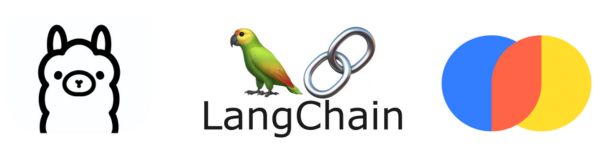

## Objective and Motivation

One of the primary motivations for Retrieval Augmented Generation (RAG) is the recognition that Large Language Models (LLMs) may not have encountered all the data relevant to your needs. Despite being trained on extensive corpora, LLMs lack access to private or specialized data that pertains to your specific requirements. Therefore, RAG enables information retrieval without the necessity of fine-tuning the LLM for your particular dataset. In essence, Retrieval Augmented Generation combines external resources with LLMs.

## Definitions

* LLM - Large Language Model
* Langchain - a framework designed to simplify the creation of applications using LLMs
* Vector database - a database that organizes data through high-dimmensional vectors
* ChromaDB - vector database
* RAG - Retrieval Augmented Generation (see below more details about RAGs)
* Ollama - a tool that allows you to run open-source large language models (LLMs) locally on your machine

## Model Details
* **Model**: gemma:7b

Gemma is a new open model developed by Google and its DeepMind team. It’s inspired by Gemini models at Google.

# What is RAG?
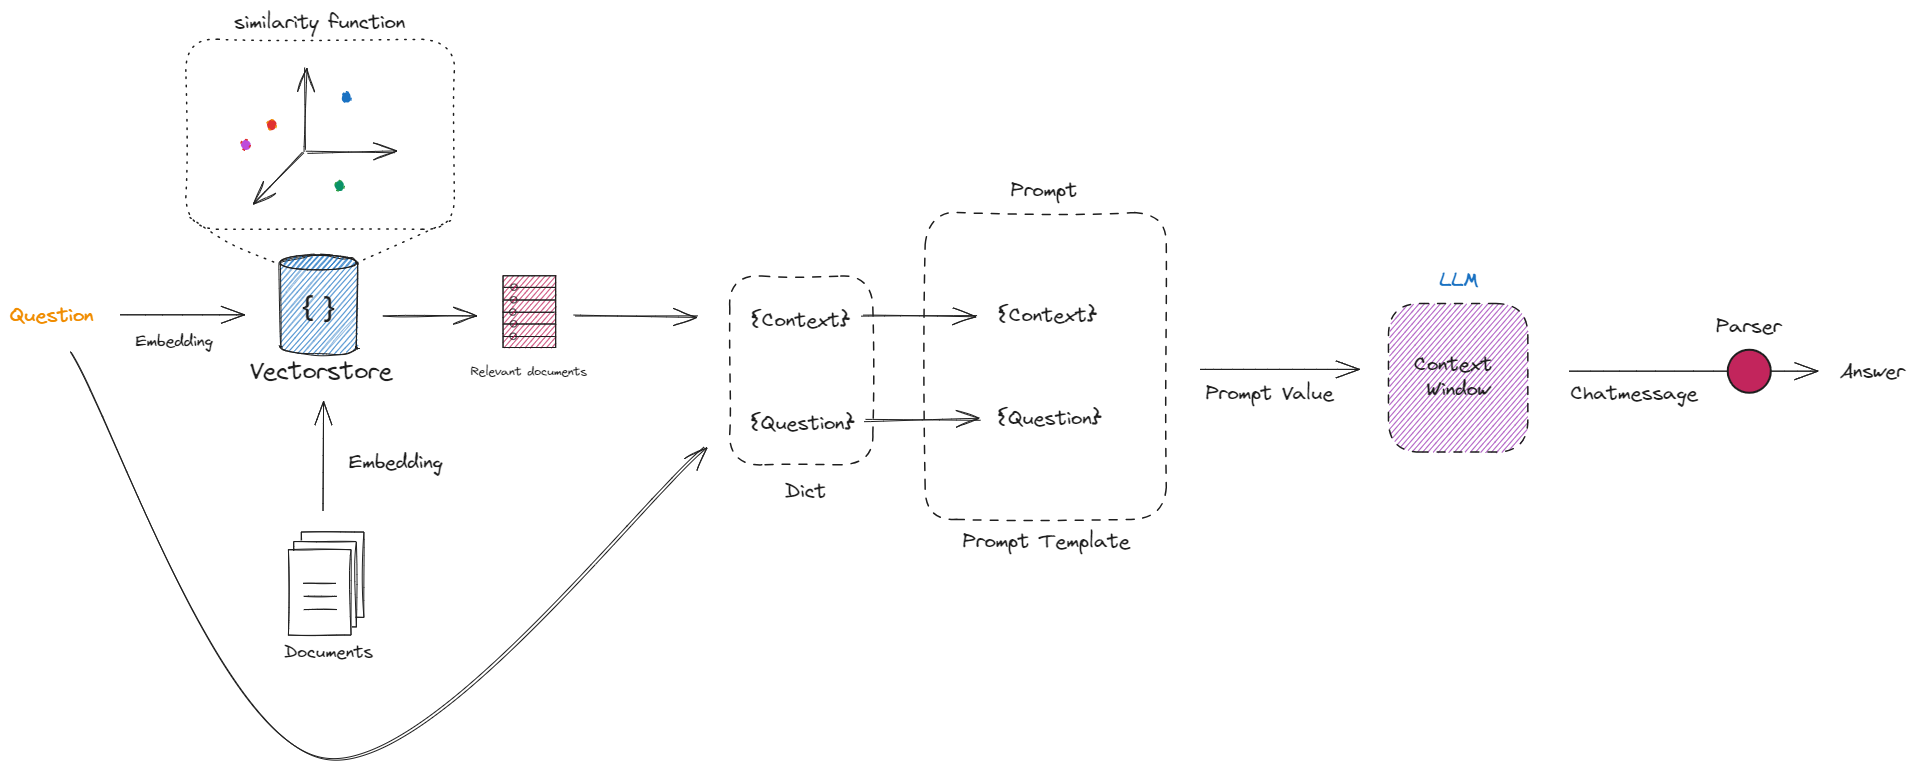

RAG serves as a technique for enhancing the knowledge of Large Language Models (LLMs) with additional data.

While LLMs possess the capability to reason about diverse topics, their knowledge is restricted to public data up to a specific training point. To develop AI applications capable of reasoning about private or post-cutoff date data, it becomes necessary to supplement the model's knowledge with specific information. This process of integrating relevant information into the model prompt is termed Retrieval Augmented Generation (RAG).

A typical RAG application comprises two main components: Indexing and Retrieval and Generation.

Indexing plays a crucial role in facilitating efficient information retrieval. Initially, data is extracted from private sources and partitioned to accommodate long text documents while preserving their semantic relations. Subsequently, this partitioned data is stored in a vector database, such as ChromaDB or Pinecone. In our case, we utilize ChromaDB for indexing purposes.

Next, in the Retrieval and Generation phase, relevant data segments are retrieved from storage using a Retriever. These segments, along with the user query, are then incorporated into the model prompt. Our approach employs an open-source local LLM, Gemma 7b, with the assistance of Ollama.

# Installations

In [1]:
! pip install -U langchain_community tiktoken chromadb langchain langchainhub sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opentelemetry-sdk to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69

# Document Loading

As the first part of the overall indexing process, we'll be loading a blog on agents.

In [2]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Splitting

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
all_splits = text_splitter.split_documents(data)

# Index

In [4]:
from langchain.embeddings import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
# Add to ChromaDB vector store
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(
    documents=all_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [6]:
question = "What are the approaches to Task Decomposition?"
docs = vectorstore.similarity_search(question)
len(docs)

4

In [7]:
docs[0]

Document(page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"})

# Model

We'll be relying on ollama to enable usage of local LLM model Gemma 7B.

# Install Ollama

In [8]:
!curl https://ollama.ai/install.sh | sh
!sudo apt install -y neofetch

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0>>> Downloading ollama...
100 10044    0 10044    0     0  27090      0 --:--:-- --:--:-- --:--:-- 27145
######################################################################## 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)





The following additional packages will be installed:
  chafa libchafa0
The following NEW packages will be installed:
  chafa libchafa0 neofetch
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 149 kB of archives.
After this operation, 633 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libchafa0 amd64 1.2.1-1 [42.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 chafa amd64 1.2.1-1 [29.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 neofetch all 7.0.0-1 [77.5 kB]
Fetched 149 kB in 1s (104 kB/s)

78Selecting previously unselected package libchafa0:amd64.
(Reading database ... 110195 files and directories currently installed.)
Preparing to unpack .../libchafa0_1.2.1-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  8%] [####......................................................] 8Unpacking libchafa0:amd64 (

In [9]:
!neofetch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


            .-/+oossssoo+/-.
        `:+ssssssssssssssssss+:`
      -+ssssssssssssssssssyyssss+-
    .ossssssssssssssssssdMMMNysssso.
   /ssssssssssshdmmNNmmyNMMMMhssssss/
  +ssssssssshmydMMMMMMMNddddyssssssss+
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/
  +sssssssssdmydMMMMMMMMddddyssssssss+
   /ssssssssssshdmNNNNmyNMMMMhssssss/
    .ossssssssssssssssssdMMMNysssso.
      -+sssssssssssssssssyyyssss+-
        `:+ssssssssssssssssss+:`
            .-/+oossssoo+/-.
root@01eb41c09f74 
----------------- 
OS: Ubuntu 20.04.6 LTS x86_64 
Host: Google Compute Engine 
Kernel: 5.15.133+ 
Uptime: 18 mins 
Packages: 660 (dpkg) 
Shell: bash 5.0.17 
CPU: Intel Xeon (4) @ 2.199GHz 
Memory: 1159MiB / 32110MiB 

               

In [10]:
OLLAMA_MODEL='gemma:7b'

# Set it at the OS level
import os
os.environ['OLLAMA_MODEL'] = OLLAMA_MODEL
!echo $OLLAMA_MODEL

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


gemma:7b


# Set up Ollama Server

In [11]:
import subprocess
import time

# Start ollama as a backrgound process
command = "nohup ollama serve&"

# Use subprocess.Popen to start the process in the background
process = subprocess.Popen(command,
                            shell=True,
                           stdout=subprocess.PIPE,
                           stderr=subprocess.PIPE)
print("Process ID:", process.pid)
# Let's use fly.io resources
#!OLLAMA_HOST=https://ollama-demo.fly.dev:443
time.sleep(5)  # Makes Python wait for 5 seconds

Process ID: 303


In [12]:
!ollama -v

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ollama version is 0.1.29


We can [use Ollama](https://ollama.com/library/gemma:7b) - 

`ollama pull gemma:7b`

In [13]:
!ollama pull gemma:7b

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠦ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest 
pulling 456402914e83...   0% ▕                ▏    

# RAG Chain
We can create a summarization chain with Gemma 7B by passing in the retrieved docs and a simple prompt.

It formats the prompt template using the input key values provided and passes the formatted string to Gemma 7B.

In [14]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Local LLM
ollama_llm = "gemma:7b"
model_local = ChatOllama(model=ollama_llm)

# Chain
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model_local
    | StrOutputParser()
)

In [15]:
# Question
chain.invoke("What are the types of agent memory?")

'The text describes two types of agent memory in the context of LLM-powered autonomous agents:\n\n- **Memory stream:** Records a comprehensive list of agents’ experience in natural language.\n- **Retrieval model:** Surfaces the context to inform the agent’s behavior based on relevance, recency and importance.'

# References

[1] LangChain, Rag From Scratch: Overview, https://github.com/langchain-ai/langchain/blob/master/cookbook/nomic_embedding_rag.ipynb

[2] LangChain, Q&A with RAG, https://python.langchain.com/docs/use_cases/question_answering/#what-is-rag

[3] LangChain, Nomic Embeddings, https://github.com/langchain-ai/langchain/blob/master/cookbook/nomic_embedding_rag.ipynb

[4] Gabriel Preda, RAG using Llama 2, Langchain and ChromaDB, https://www.kaggle.com/code/gpreda/rag-using-llama-2-langchain-and-chromadb

[5] Adrien Sales, 🦙 ollama running local models w/LlamaIndex (CPU), https://www.kaggle.com/code/adriensales/ollama-running-local-models-w-llamaindex-cpu

# Next Steps

I'll be looking to replicate a few papers on query translation next. Please look forward to it.